In [1]:
import pickle, glob, sys, os, warnings, csv

import numpy as np
import matplotlib.pyplot as plt

from datetime import datetime
from time import time

from scipy.stats import gamma
from scipy.stats import multivariate_normal, norm

# Import All custom functions
from detection_clustering_utils import *
from feature_extraction_utils import *
from cloud_velocity_vector_utils import *
from image_processing_utils import *
from cloud_segmentation_utils import *
from wind_velocity_field_utils import *
from lib_motion_vector import _farneback, _lucas_kanade, _pyramidal_weighted_lucas_kanade, _weighted_lucas_kanade
from utils import *
# Import frame-Class, models, aand paramters
from config import _frame
# Import functions for a single layer wind velocity field
from extra import *
from files import *

# Do not display warnings in the output file
warnings.filterwarnings('ignore')

In [2]:
# Compute statisticd of features (Modify this Code)
def _get_stats(K_0_, K_1_, K_2_, K_3_, H_2_, N_2_, M_, D_, V_, W_):
    # Computed Weighted mean an variance
    def __stats(X_, W_):
        # Vectors Definitio
        x_ = X_.flatten()
        w_ = W_.flatten()
        o_ = np.ones(x_.shape)
        # Weights Normalization
        w_ /= w_.sum()
        # Weighted Sample Mean
        mu = (w_.T @ x_) / (o_.T @ w_)
        z_ = (x_ - mu)
        # Weighted Sample Variance
        s = ( z_.T @ (np.eye(w_.shape[0])*w_) @ z_ ) / (o_.T @ w_)
        # Weighted Sample Skewness
        g = ( w_.T @ z_**3 / (o_.T @ w_) ) / ( w_.T @ z_**2 / (o_.T @ w_) )**(3/2)
        # Weighted Sample Kurtosis
        k = ( w_.T @ z_**4 / (o_.T @ w_) ) / ( w_.T @ z_**2 / (o_.T @ w_) )**2
        # Make sure there are no Nans
        return np.nan_to_num(mu), np.nan_to_num(s), np.nan_to_num(g), np.nan_to_num(k)
    # Compute Cloud Features Statistics
    m_m, s_m, g_m, k_m = __stats(M_, W_)
    m_d, s_d, g_d, k_d = __stats(D_, W_)
    m_v, s_v, g_v, k_v = __stats(V_, W_)
    m_h, s_h, g_h, k_h = __stats(H_2_, W_)
    # Compute Clouds Temperature Statistics
    m_k0, s_k0, g_k0, k_k0 = __stats(K_0_, W_)
    m_k1, s_k1, g_k1, k_k1 = __stats(K_1_, W_)
    m_k2, s_k2, g_k2, k_k2 = __stats(K_2_, W_)
    m_k3, s_k3, g_k3, k_k3 = __stats(K_3_, W_)
    m_n,  s_n,  g_n,  k_n  = __stats(N_2_, W_)
    # Get Features Statistics
    m_feat_ = np.asarray([m_m, m_d, m_v, m_h])
    s_feat_ = np.asarray([s_m, s_d, s_v, s_h])
    g_feat_ = np.asarray([g_m, g_d, g_v, g_h])
    k_feat_ = np.asarray([k_m, k_d, k_v, k_h])
    # Get Temperature Statistics
    m_temp_ = np.asarray([m_k0, m_k1, m_k2, m_k3, m_n])
    s_temp_ = np.asarray([s_k0, s_k1, s_k2, s_k3, s_n])
    g_temp_ = np.asarray([g_k0, g_k1, g_k2, g_k3, g_n])
    k_temp_ = np.asarray([k_k0, k_k1, k_k2, k_k3, k_n])
    return m_feat_, s_feat_, g_feat_, k_feat_, m_temp_, s_temp_, g_temp_, k_temp_

def _autoregressive_param_v0(Mu_, Cov_, m_hat_, C_hat_, e_, error_, k, lag = 10):
    error = error_[-1]
    #if k == 0:
    mu_e  = np.nan_to_num(np.mean(e_), nan = 0.)
    std_e = np.nan_to_num(np.std(e_), nan = 0.)
    prob  = np.nan_to_num(norm(mu_e, std_e).pdf(error), nan = 1.)
    # Save Parameters if there is not risen flag
    if np.isnan(m_hat_).any() or np.isnan(C_hat_).any() or (prob < 0.03):
        print('Flag!')
    else:
        # Keep the desire number of lags on the list by removing the last and aadding at the bigging
        if len(Mu_[k]) == lag:
            Mu_[k].pop(0)
            Cov_[k].pop(0)
        if len(e_) == lag and (k == 0):
            e_.pop(0)
        # Keep adding until we have the desired number of lag time stamps
        Mu_[k].append(m_hat_)
        Cov_[k].append(C_hat_)
    if k == 0: e_.append(error)
    # Do I want to average Parameters in last lags?
    m_hat_ = Mu_[k][-1]
    C_hat_ = Cov_[k][-1]
    return Mu_, Cov_, e_, m_hat_, C_hat_

def _autoregressive_param_v1(Mu_, Cov_, m_hat_, C_hat_, e_, error_, k, lag = 10):
    error = error_[-1]
    mu_e  = np.nan_to_num(np.mean(e_), nan = 0.)
    std_e = np.nan_to_num(np.std(e_), nan = 0.)
    _N    = norm(mu_e, std_e)
    ci_   = _N.interval(0.95)
    prob  = np.nan_to_num(_N.pdf(error), nan = 1.)
    if k == 3:
        e_.append(error)
    if prob < 0.025:
        pass
    else:
        # Keep the desire number of lags on the list by removing the last and aadding at the bigging
        if len(Mu_[k]) == lag:
            Mu_[k].pop(0)
            Cov_[k].pop(0)
        if len(e_) == lag and (k == 3):
            e_.pop(0)
        # Keep adding until we have the desired number of lag time stamps
        Mu_[k].append(m_hat_)
        Cov_[k].append(C_hat_)
    # Do I want to average Parameters in last lags?
    m_hat_ = np.mean(np.stack(Mu_[k]), axis = 0)
    C_hat_ = np.mean(np.stack(Cov_[k]), axis = 0)
    return Mu_, Cov_, e_, m_hat_, C_hat_


def _get_covariates(X_, lag, index):
    idx, t, py_, gsi_, csi_, el_, az_ = X_[index][0]
    ref_  = np.asarray([i, t])
    angl_ = np.asarray([el_, az_])
    auto_ = [[csi_, gsi_, py_],]
    for l in range(1, lag):
        idx, t, py_, gsi_, csi_, el_, az_  = X_[index - l][0]
        auto_.append([csi_, gsi_, py_])
    return ref_, angl_, np.stack(auto_)

def _get_predictors(X_, horion, index):
    idx, t, py_, gsi_, csi_, el_, az_ = X_[index + horion][0]
    return np.asarray([csi_, gsi_, py_])

# Finding index of pixels expecting to intercept the Sun for each horizon (k)
def _sun_intercepting_line(Phi_, Psi_, x_0_, A_0_):
    # Selecting pixels by streamlines and potential lines that intercept the Sun
    def __select_intercepting_potential(Psi_0):
        return Psi_ > Psi_0
    # Connected components form the Sun streamline alon equipotential streamlines
    def __select_intercepting_streamline(Phi_, Psi_, x_0, y_0, Phi_0, idx_potential_):
#         # Finding connected pixel
#         def ___next_pixel_coordiantes(Phi_, Psi_, i, j, idx_):
#             # Streamline Value in Current Pixel
#             Psi_0 = Psi_[i,j]
#             # Defining errors matrix
#             E_ = np.zeros((3, 3))
#             # loop over nerbouring pixels
#             for k in [-1, 0, 1]:
#                 for m in [-1, 0, 1]:
#                     if k == 0 and m == 0:
#                         E_[1 + k, 1 + m] = - np.inf
#                     else:
#                         E_[1 + k, 1 + m] = Phi_[i + k, j + m] 
#             # Unravel error matrix coordiantes of min value error
#             k_, m_ = np.where(E_ == E_.max())
#             # Updating new streamline pixel coordiantes
#             i_new, j_new = i + k_[0] - 1, j + m_[0] - 1
#             return i_new, j_new
        # Finding connected pixel
        def ___next_pixel_coordiantes(Phi_, Psi_, i, j, idx_):
            Psi_0 = Psi_[i,j]
            # Defining errors matrix
            E_ = np.zeros((3, 3))
            W_ = np.zeros((3, 3))
            # loop over nerbouring pixels
            for k in [-1, 0, 1]:
                for m in [-1, 0, 1]:
                    #C_ = idx_[i + k - 1: i + k + 2, j + m - 1: j + m + 2]
                    if k == 0 and m == 0:
                        E_[1 + k, 1 + m] = np.inf
                    else:
                        E_[1 + k, 1 + m] = (Phi_0 - Phi_[i + k, j + m])**2
                        W_[1 + k, 1 + m] = Psi_[i + k, j + m] - Psi_0
            # Unravel error matrix coordiantes of min value error
            idx_ = W_ <= 0.
            k_, m_ = np.where(E_ == E_[idx_].min())
            # Updating new streamline pixel coordiantes
            i_new, j_new = i + k_[0] - 1, j + m_[0] - 1
            return i_new, j_new
        # Find the trasition on the connected components of the streamlines
        def __get_transitions_index(i_0, j_0, i, j):
            a, b = 0, 0
            if i_0 != i: a = 1
            if j_0 != j: b = 1
            return [a, b]
        # Variables initialization
        idx_1_   = idx_potential_.copy()
        idx_2_   = np.zeros((N_y, N_x), dtype = int)
        idx_3_   = []
        # Initilization Optimization Scheme in the Detected Sun Position 
        i_0, j_0 = y_0, x_0
        # Position Initialization
        count = 1
        # Compute probability of a pixel in the image intersecting the Sun
        plt.figure()
        plt.imshow(Phi_)
        plt.colorbar()
        X_ = np.sqrt((Phi_ - Phi_[i_0, j_0])**2)
        plt.figure()
        plt.imshow(X_)
        plt.colorbar()
        X_ = X_.max() - X_
        
        plt.figure()
        plt.imshow(X_)
        plt.colorbar()
        
        # Define Riemann-Cauchy Equation for a Complex Function
        Z_ = X_ + 1j*Psi_
        # Define Potential Flow Constrain
        W_ = 1. + 1.*idx_potential_
        # Compute Probability wave
        X_ = W_*np.absolute(Z_)**2 
        # Probability Wave Normalization
        X_ = X_/X_.sum()
        # Define Conecting Components Optimization Scheme function the probability wave
        #Phi_  = X_.copy()
        Phi_0 = Phi_[i_0, j_0]
        # Loop to the edge of the frame
        while True:
            # Update Counter Variable
            count += 1
            # Finding next pixel on the streamline
            i, j = ___next_pixel_coordiantes(Phi_, Psi_, i_0, j_0, idx_1_)
            # Updating Pixel positon in the Streamline
            idx_1_[i, j] = True
            idx_2_[i, j] = count
            # Update Repeated Pixels in Streamline Constrain           
            #Phi_[i, j] = 0.
            # Get Quatified Pixels Transitions along Streamline
            idx_3_.append(__get_transitions_index(i_0, j_0, i, j))
            # Update Current Pixel
            i_0 = i.copy()
            j_0 = j.copy()
            # Finding the edge
            if (i >= 59 or i <= 0) or (j >= 79 or j <= 0):
                break
        # Define Probability wave without contains
        Z_potential_  = np.absolute(Z_)**2 
        # Normilized Unconstrained Probability Wave
        Z_potential_ /= Z_potential_.sum()   
        return idx_2_, idx_3_, Z_potential_
    # Sun position on integer value to use it as indexing value
    x_0 = int(np.around(x_0_[0]))
    y_0 = int(np.around(x_0_[1]))
    # Sun-interceptig streamline
    phi_0 = Phi_[y_0, x_0]
    psi_0 = Psi_[y_0, x_0]
    # Feassible Sun intercepting potential line Pixels index
    idx_potential_line_ = __select_intercepting_potential(psi_0)  
    # Selecting Sun intercepting streamline Pixels index
    idx_streamline_, idx_transitions_, Z_potential_ = __select_intercepting_streamline(Phi_, Psi_, x_0, y_0, phi_0, idx_potential_line_)
    return idx_potential_line_, idx_streamline_, idx_transitions_, Z_potential_

# Finding index of pixels expecting to intercept the Sun for each horizon (k)
def _time_intersecting_dist(UV_hat_, dXYZ_, idx_streamline_, idx_transitions_, error_):
    # Estimate circule center for selection according to estimate arrivale time of a pixel
    def __estimate_interception(dXYZ_, U_, V_, e_u, e_v, phi_, transitions_, idx_phi_):
        # For an unbiased estimator, the RMSD is the square root of the variance, known as the standard deviation.
        def ___compute_time_uncertanty(dx_, dy_, u_, v_, transitions_, e_u, e_v):
            # Variables Initialization
            a_hat_ = np.zeros((len(transitions_),))
            b_hat_ = np.zeros((len(transitions_),))
            t_bar_ = np.zeros((len(transitions_),))
            dz_    = np.zeros((len(transitions_),))
            # Calculate the distance components for each streamline pixel
            for i, transition_ in zip(range(len(transitions_)), transitions_):
                # Draw samples
                e_u_ = np.random.normal(loc = 0, scale = e_u, size = 1000)
                e_v_ = np.random.normal(loc = 0, scale = e_v, size = 1000)
                a_x, a_y = transition_
                # Calculate the velocity components for each streamline pixel
                w_samples_ = np.sqrt((u_[i] + e_u_)**2 + (v_[i] + e_v_)**2)
                # Calculate the distance to traverse in a pixel
                dz_[i] = np.sqrt(a_x*dx_[i]**2 + a_y*dy_[i]**2)
                # Compute Time
                T_samples_ = dz_[i]/w_samples_
                # Approximation of ML the Gamma Distribution Parameters
                a_hat_[i] = 0.5/(np.log(np.mean(T_samples_)) - np.mean(np.log(T_samples_)))
                b_hat_[i] = np.mean(T_samples_)/a_hat_[i]
                # Mean of the Gamma Distribution
                t_bar_[i] = a_hat_[i]*b_hat_[i]
            return a_hat_, b_hat_, t_bar_, dz_    
        # Initialize variables, identify pixels on the streamline, and proximity sorting index definition
        idx_ = np.argsort(phi_[idx_phi_] - 1)
        # Velocity compoenents
        u_ = U_[idx_phi_][idx_]
        v_ = V_[idx_phi_][idx_]
        # Numerical differenciation on a non-linear frame-metric
        dx_ = dXYZ_[idx_phi_, 0][idx_]
        dy_ = dXYZ_[idx_phi_, 1][idx_]
        # Compute propagate the undertanty in the velocity vectors to the time
        return ___compute_time_uncertanty(dx_, dy_, u_, v_, transitions_, e_u, e_v)
    # Get uncertanties on the velocity fectors estimation
    e_z, e_u, e_v = error_
    # Saparete Velocity components and transform time from seconds to frames
    ifps   = 15.
    U_hat_ = UV_hat_[..., 0]*ifps
    V_hat_ = UV_hat_[..., 1]*ifps
    e_u *= ifps
    e_v *= ifps
    e_z *= ifps
    # Indexes of Pixels in the Intersecting Streamline
    idx_phi_ = idx_streamline_ > 0
    # Time estimation for intercepting the Sun for each pixel on the streamline
    return __estimate_interception(dXYZ_, U_hat_, V_hat_, e_u, e_v, idx_streamline_, idx_transitions_, idx_phi_)

# Compute a Pixel Intersecting Uncertanty in Space
def _space_intersecting_dist(UV_hat_, XYZ_, idx_streamline_, a_hat_, b_hat_, t_bar_, 
                             error_, x_0_, dz_, g, convolution = False):
    # Compute propagate the undertanty in the velocity vectors to the space
    def __compute_space_uncertanty(g, u, v, e_u, e_v):
        # Draw samples
        e_u_ = np.random.normal(loc = 0, scale = e_u, size = 1000)
        e_v_ = np.random.normal(loc = 0, scale = e_v, size = 1000)
        # Calculate the velocity components for each streamline pixel
        w_samples = np.sqrt((u + e_u_)**2 + (v + e_v_)**2)
        # Compute Distance
        X_samples_ = g*w_samples
        # Inference distribution from samples
        return np.eye(2)*np.var(X_samples_)
    # Indexes of Pixels in the Intersecting Streamline
    idx_phi_ = idx_streamline_ > 0
    # Initialize variables, identify pixels on the streamline, and proximity sorting index definition
    idx_ = np.argsort(idx_streamline_[idx_phi_] - 1)
    # Distances in non-linear coordinates
    x_ = XYZ_[idx_phi_, 0][idx_]
    y_ = XYZ_[idx_phi_, 1][idx_]
    # Arrival Time Distribution
    z_ = np.zeros(t_bar_.shape)
    #w_ = np.zeros(t_bar_.shape)
    cum_a_hat_ = np.cumsum(a_hat_)
    for i in range(t_bar_.shape[0]): 
        z_[i] = gamma(cum_a_hat_[i], loc = 0, scale = np.mean(b_hat_)).pdf(g)
        #w_[i] = norm(cum_a_hat_[i]*np.mean(b_hat_), cum_a_hat_[i]*(np.mean(b_hat_)**2)).pdf(g)
    # Intersecting Pixels Time Distribution     
    t_  = cum_a_hat_*np.mean(b_hat_)
    dt_ = np.diff(np.insert(cum_a_hat_, 0, 0)*np.mean(b_hat_))    
    n_  = z_*t_*dt_
    # Compute ML Parameters of the Intersecting Multivariate Normal Distribution
    X_   = np.concatenate((x_[:, np.newaxis], y_[:, np.newaxis]), axis = 1)
    P_   = np.tile(n_/n_.sum(), (2, 1)).T
    x_c_ = np.sum(X_*P_, axis = 0)#[:, np.newaxis]
    X_c_ = np.tile(x_c_[:, np.newaxis], (1, P_.shape[0])).T
    G_   = np.eye(P_.shape[0]) * n_/n_.sum()
    S_c_ = (X_ - X_c_).T @ G_ @ (X_ - X_c_)    
    if convolution:
        # Reprojected Distance from the Sun to the Pixel
        x  = int(np.around(x_0_[0]))
        y  = int(np.around(x_0_[1]))   
        Z_ = np.concatenate(((XYZ_[..., 0] - XYZ_[y, x, 0]).flatten()[:, np.newaxis], 
                             (XYZ_[..., 1] - XYZ_[y, x, 1]).flatten()[:, np.newaxis]), axis = 1)
        W_ = np.sqrt(Z_[..., 0]**2 + Z_[..., 1]**2)
        # Analytical Solution of the Covolution of two Gaussians
        p = 1.
        S_c_ += np.cov(Z_[~np.argsort(W_)[:int(p*4800)], :].T)  
    else:
        # Get uncertanties on the velocity fectors estimation
        e_z, e_u, e_v = error_
        # Saparete Velocity components and transform time from seconds to frames
        ifps   = 15.
        U_hat_ = UV_hat_[..., 0]*ifps
        V_hat_ = UV_hat_[..., 1]*ifps
        e_u *= ifps
        e_v *= ifps
        e_z *= ifps
        # Velocity components
        u_hat_ = U_hat_[idx_phi_][idx_]
        v_hat_ = V_hat_[idx_phi_][idx_]
        # Compute Expected Intesecting Velocity components
        u_hat_bar_ = np.zeros((dz_.shape[0],))
        v_hat_bar_ = np.zeros((dz_.shape[0],))
        for i in range(1, dz_.shape[0] + 1):
            for j in range(i):
                u_hat_bar_[i - 1] += u_hat_[j] * dz_[j]
                v_hat_bar_[i - 1] += v_hat_[j] * dz_[j]
            u_hat_bar_[i - 1] /= dz_[:j + 1].sum()
            v_hat_bar_[i - 1] /= dz_[:j + 1].sum()
        # Normal Distribution Parameters Approximation
        o_    = np.ones(z_.shape)
        u_hat = (n_.T @ u_hat_bar_) / (o_.T @ n_)
        v_hat = (n_.T @ v_hat_bar_) / (o_.T @ n_)
        # Compute propagate the undertanty in the velocity vectors to the space
        S_c_ +=  __compute_space_uncertanty(g, u_hat, v_hat, e_u, e_v)
    return x_c_, S_c_

/users/terren/wheeler-scratch/data_feature_extraction_v2/2018_04_11.pkl
0 0 1784
1746 1746


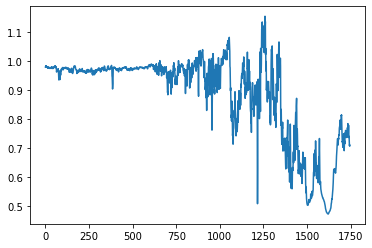

In [24]:
# Run Feature Quantification for a given interval
def _run_feature_quantification(X_, Mu_, Cov_, data_, e_, g_, j):    
    # Extract Radiometry Features
    K_0_, K_1_, K_2_, H_2_, N_2_, I_segm_, Z_segm_, x_0_, A_0_, T = X_[j][1]
    # Compute Relative Temperature w.r.t. the Tropopause
    K_3_ = K_2_ - T/100.
    # Get Sample Reference Time Series and Angles Features
    ref_, angl_, auto_ = _get_covariates(X_, lag, index = j)
    # Loop over forecating horizons
    pred_ = []
    for k in range(len(g_)):
        pred_.append( _get_predictors(X_, g_[k], index = j) )
    pred_ = np.stack(pred_)
    
    # Initialize Variable
    M_f_ = np.zeros((4, len(g_)))
    S_f_ = np.zeros((4, len(g_)))
    G_f_ = np.zeros((4, len(g_)))
    K_f_ = np.zeros((4, len(g_)))
    M_t_ = np.zeros((5, len(g_)))
    S_t_ = np.zeros((5, len(g_)))
    G_t_ = np.zeros((5, len(g_)))
    K_t_ = np.zeros((5, len(g_)))
        
    # Quantified Features only if enough clouds were detected to estimate the wind flow
    if len(X_[j]) != 2:
        # Extract Flow Features
        height, UV_hat_, Phi_, Psi_, XYZ_, dXYZ_, WRMSE_ = X_[j][2][0]
        # Extract Cloud Velocity Vectors Features
        M_, D_, V_ = X_[j][3]
        # Adjust Prespective transformation to current height
        dXYZ_ = height*dXYZ_
        XYZ_  = height*XYZ_
        
#         plt.figure()
#         plt.imshow(N_2_)
#         plt.show()
        
        
        # Compute Intercepting Streamline
        idx_potential_line_, idx_streamline_, idx_transitions_, Z_potential_ = _sun_intercepting_line(Phi_, 
                                                                                        Psi_, x_0_, A_0_)
        
#         plt.figure()
#         plt.imshow(Phi_)
#         plt.show()
        
#         plt.figure()
#         plt.imshow(Z_potential_)
#         plt.show()
        
        # Infer the Parameters of the distribution of the pixel intercepting the Sun
        a_hat_, b_hat_, t_bar_, dz_ = _time_intersecting_dist(UV_hat_, dXYZ_, idx_streamline_, 
                                                          idx_transitions_, WRMSE_)

#         plt.figure()
#         plt.subplot(121)
#         plt.imshow(idx_streamline_)
#         plt.subplot(122)
#         plt.imshow(N_2_, cmap = 'inferno')
#         plt.contour(Z_potential_, cmap = 'jet', levels = 25)


        #plt.contour(Phi_, colors = 'lime', label = 'Streamline')
        #plt.contour(Psi_, colors = 'blue', label = 'Potential')
        plt.show()
        print(_divergence(UV_hat_[..., 0], UV_hat_[..., 1]).mean(), 
              _vorticity(UV_hat_[..., 0], UV_hat_[..., 1]).mean())
        print(WRMSE_)
        print((idx_streamline_ > 0.).sum())
        print(N_2_.mean(), Phi_.mean(), Psi_.mean())
        
        # Loop over forecating horizons
        for k in range(len(g_)):
            # Infer the Parameters of the distribution of the pixel intercepting the Sun
            m_hat_, C_hat_ = _space_intersecting_dist(UV_hat_, XYZ_, idx_streamline_, a_hat_, b_hat_, t_bar_, 
                                                      WRMSE_, x_0_, dz_, g_[k])
            # Autoregressive smoothing v0 or v1 <- Is proved to perform  better
            if v == 0: Mu_, Cov_, e_, m_hat_, C_hat_ = _autoregressive_param_v0(Mu_, Cov_, m_hat_, C_hat_, 
                                                                                e_, WRMSE_, k)
            if v == 1: Mu_, Cov_, e_, m_hat_, C_hat_ = _autoregressive_param_v1(Mu_, Cov_, m_hat_, C_hat_, 
                                                                                e_, WRMSE_, k)
            # Compute the Probabilitiy of intercepting the Sun of each Pixel given the horion g-th
            Z_sector_ = multivariate_normal(m_hat_, C_hat_).pdf(XYZ_[..., :2].reshape(N_y*N_x, 2)).reshape(N_y, N_x)
            # Normalize Conditional Probabilities
            Z_sector_    /= Z_sector_.sum()
            Z_potential_ /= Z_potential_.sum()
            Z_  = Z_sector_# *Z_potential_
            Z_ /= Z_.sum()
            #W_ = Z_ > 0. #* Z_segm_ #v3
            W_  = Z_ # v2
            
            plt.figure()
            plt.imshow(N_2_, cmap = 'inferno')
            plt.contour(Phi_, colors = 'lime', label = 'Streamline')
            plt.contour(Psi_, colors = 'red', label = 'Potential')
            plt.contour(Z_, cmap = 'jet', levels = 30, alpha = 0.5)
            plt.show()
            
            # Quantify Cloud Features
            M_f_[:, k], S_f_[:, k], G_f_[:, k], K_f_[:, k], M_t_[:, k], S_t_[:, k], G_t_[:, k], K_t_[:, k] = _get_stats(K_0_, K_1_, K_2_, K_3_,
                                                                                                                        H_2_, N_2_, M_, D_, V_, W_)
    else:
        print('Clear-Sky!')
        
    # Save Quantified Features
    data_.append([ref_, K_3_, pred_, angl_, auto_, [M_f_, S_f_, G_f_, K_f_, M_t_, S_t_, G_t_, K_t_]])
        
    return data_

# Open Feature Extraction File
def _open_file(file_name_):
    with open(file_name_, 'rb') as file: 
        X_ = pickle.load(file)
    return X_

# Save Quantfied Features in file
def _save_file(data_, filename_, save_path):
    print(len(data_), filename_)
    with open(filename_, 'wb') as file:
        pickle.dump(data_, file, protocol = pickle.HIGHEST_PROTOCOL)


# Configure Selection on a given Day
day = 19
intervals_ = [[50, 100], [150, 200], [250, 300]]
# Configure Selection of Features
lag = 6
g_  = [4, 8, 16, 32]
v = 1
# Get Files in Directory
#name        = r'/Users/Guille/Desktop/solar_forecasting/data/data_feature_extraction_v2/*'
name        = r'/users/terren/wheeler-scratch/data_feature_extraction_v2/*'
file_names_ = sorted(glob.glob(name))

N_y = 60
N_x = 80

# Loop over files
for i in range(day, day + 1):
    print(file_names_[i])
    # Open Feature Extraction File
    X_ = _open_file(file_names_[i])
    intervals_ = [[0, len(X_)]]
    # Loop over intervals in the Days
    for interval_, idx in zip(intervals_, range(len(intervals_))):
        print(idx, interval_[0], interval_[1])
        # Storage Variables Initialization
        Mu_, Cov_ = [[], [], [], []], [[], [], [], []]
        data_, e_ = [], []
        time_, CSI_ = [], []
        # Loop over samples in a file
        for j in range(interval_[0] + lag, interval_[1] - g_[-1]):
            #print(interval_[0] + lag, j, interval_[1] - g_[-1])
            
            idx, t, py_, gsi_, csi_, el_, az_ = X_[j][0]
            time_.append(t)
            CSI_.append(csi_)
            #try:
            #Run Feature quantification in the interval
            #data_ = _run_feature_quantification(X_, Mu_, Cov_, data_, e_, g_, j)
#             except:
#                 print(m_hat_, C_hat_)
#                 print('error!')
#                 pass
print(len(time_), len(CSI_))

plt.figure()
plt.plot(np.array(CSI_))
plt.show()
# Save Quantfied Features in file
# _save_file(data_, filename_= r'{}/{}-{}'.format(save_path, idx, file_names_[i][-14:]), 
#            save_path = r'/users/terren/wheeler-scratch/database_feature_selection_v13')